# NTEM data report

In [1]:
import NTEM_process as nt
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
import statsmodels as sm
import statsmodels.formula.api as smf
from patsy import dmatrices

In [2]:
pop_NTEM = nt.process_df('pop')
emp_NTEM = nt.process_df('emp')
pop_TfN = pd.read_csv(r"C:\Projects\MidMITS\NTEM\SHP\pop\landuse 2021 complete_pop.csv").set_index(['msoa_zone_id','pop code','tfn_traveller_type']).join(pop_NTEM['pct'])
emp_TfN = pd.read_csv(r"C:\Projects\MidMITS\NTEM\SHP\emp\landuse 2021 complete_emp.csv").set_index(['msoa_zone_id','emp code','tfn_traveller_type']).join(emp_NTEM['pct'])
pop_TfN_abs = nt.apply_abs('pop')
emp_TfN_abs = nt.apply_abs('emp')

In [3]:
compare_pop = pop_TfN.groupby(['msoa_zone_id','pop code']).sum().join(pop_NTEM.groupby(['msoa_zone_id','pop code']).sum(),lsuffix=' TfN',rsuffix=' NTEM')[['2018 TfN','2018 NTEM']]
compare_pop['pct'] = abs((compare_pop['2018 TfN']-compare_pop['2018 NTEM'])/compare_pop['2018 TfN'])
compare_pop['diff'] = compare_pop['2018 TfN']-compare_pop['2018 NTEM']
compare_pop.columns = ['TfN', 'NTEM', 'pct', 'diff']
compare_emp = emp_TfN.groupby(['msoa_zone_id','emp code']).sum().join(emp_NTEM.groupby(['msoa_zone_id','emp code']).sum(),lsuffix=' TfN',rsuffix=' NTEM')[['2018 TfN','2018 NTEM']]
compare_emp['pct'] = abs((compare_emp['2018 TfN']-compare_emp['2018 NTEM'])/compare_emp['2018 TfN'])
compare_emp['diff'] = compare_emp['2018 TfN']-compare_emp['2018 NTEM']
compare_emp.columns = ['TfN', 'NTEM', 'pct', 'diff']

In [26]:
pop_2021 =pd.concat([pop_TfN['2021'],pop_TfN_abs['2021']],axis=1)
pop_2021.columns = ['pct','abs']
emp_2021 =pd.concat([emp_TfN['2021'],emp_TfN_abs['2021']],axis=1)
emp_2021.columns = ['pct','abs']

We've calculated factors for the period 2018 to 2021 from NTEM data for the period 2016-2021, and applied those factors to TfN landuse data using a correspondence between the NTEM categories and TfN categories; for employment categories they match up more or less 1:1, whereas for population TfN has 760 categories and NTEM only 88, so there are often many TfN categories for one NTEM.  Because of this the employment data scales up much more evenly than population, with fewer problems.  The issue with the process is that sometimes there can be a jump from a very low number upwards, giving a high percentage growth (as growth is calculated as 2021 / 2018, so if 2018 is very low this percentage will be high).  For this reason where 2018 and 2021 both show zero for a given NTEM category and MSOA, the growth rate is set to one, and where it is zero for either 2016 or 2021 the growth rate is set to the average growth for that category.  Despite this we still get some 'large factors applied to large numbers' in the TfN data.  When we do various plots of NTEM against TfN landuse data for the base year (2018) we see that they are quite varied.  I.e. for a given NTEM population code it can sometimes be high in the NTEM data, and low in TfN (where TfN is summed over that zone for the various corresponding TFN codes).  Below are plotted overall NTEM vs TfN data (where each point is the same NTEM population code and MSOA), and the same data grouped by MSOA and pop code respectively.  The first row is for population data, which you can see is not particularly well correlated, and the second row is for employment which is much better (nb, the employment data actually contains about 1/7th of the data points of population, but appears less than this as the data is much closer grouped).

## Plots of 2018 data at NTEM category level, NTEM on Y axis and TfN on X.  Population first row and employment second, the left most being all data, then grouped by msoa and category respectively

<AxesSubplot:xlabel='TfN', ylabel='NTEM'>

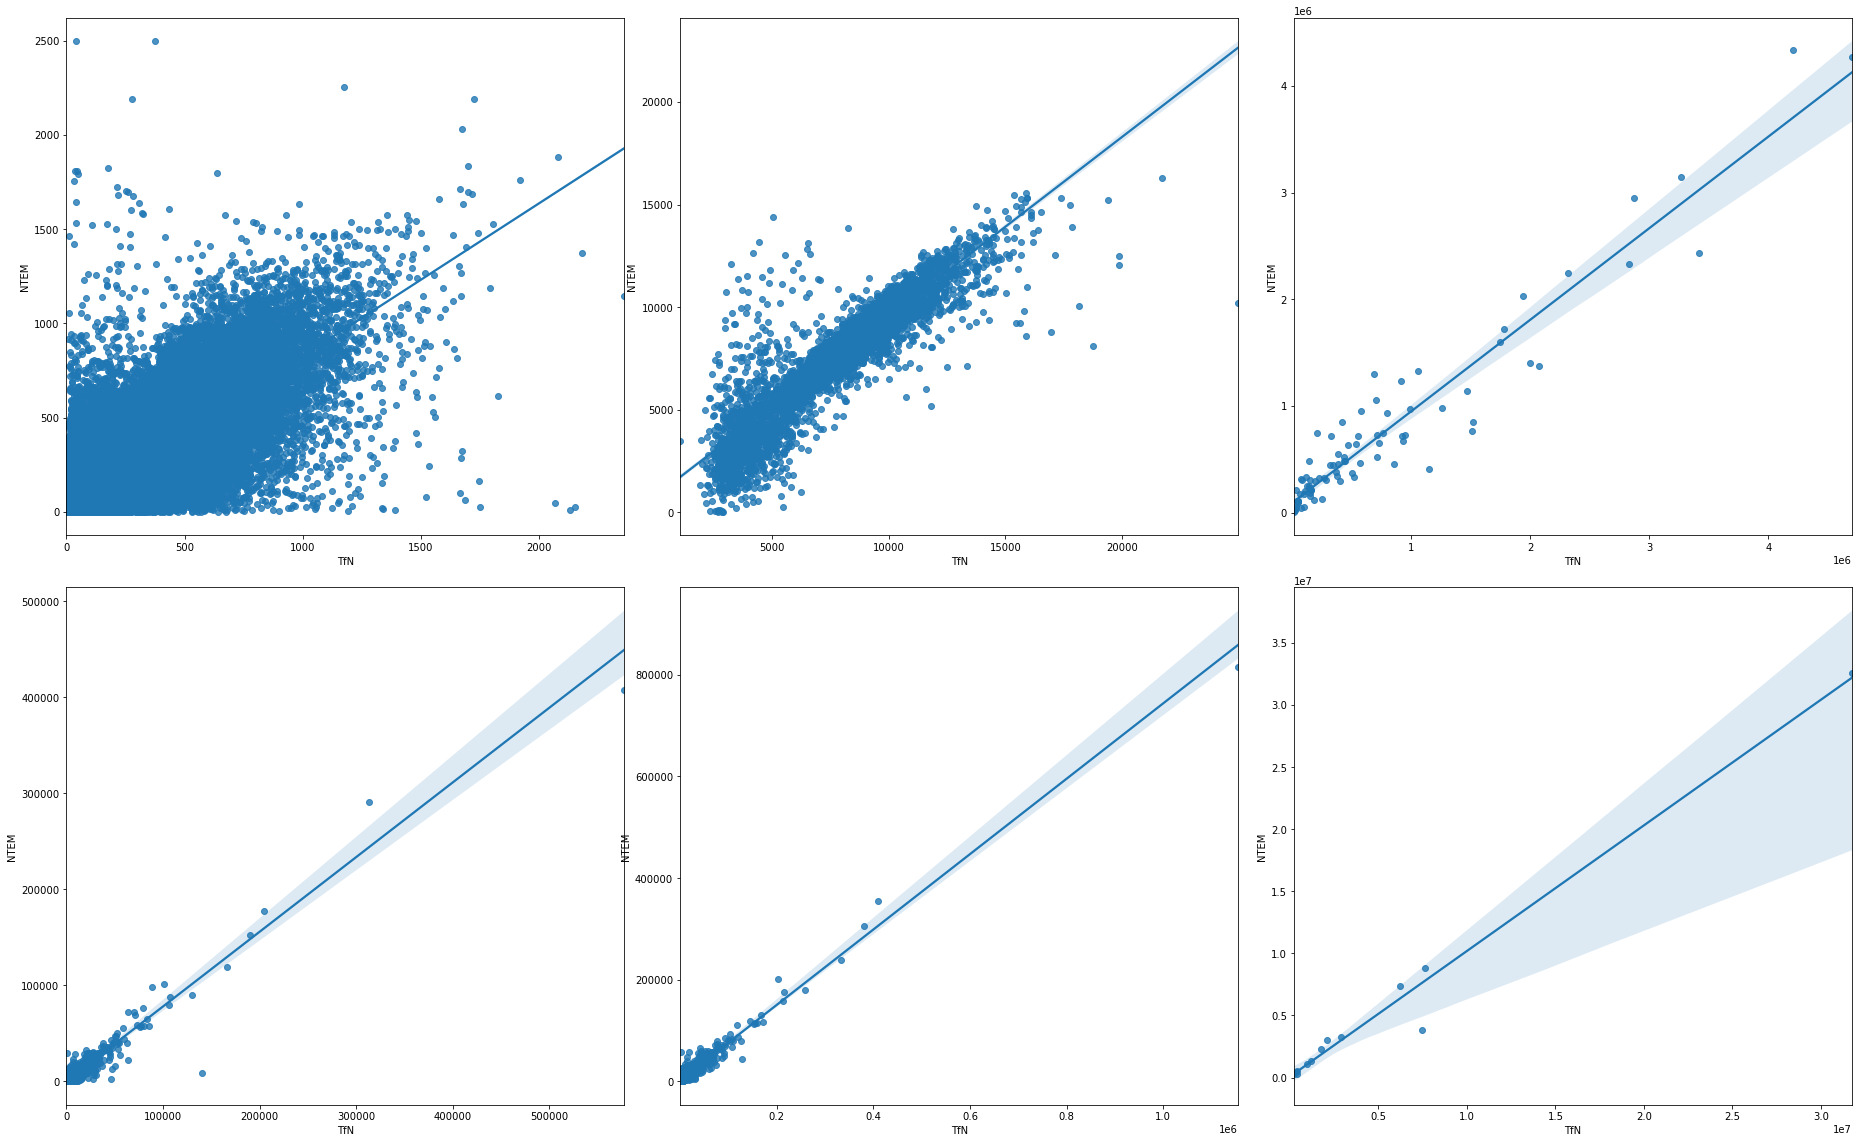

In [17]:
# sns.lmplot(x='TfN',y='NTEM',data=compare,fit_reg = True,height=20,aspect=1,hue='pop code',legend=True)
# sns.lmplot(x='TfN',y='NTEM',data=compare,fit_reg = True,height=20,aspect=1,hue='pop code',legend=True)
# sns.lmplot(x='TfN',y='NTEM',data=compare,fit_reg = True,height=20,aspect=1,hue='pop code',legend=True)
fig = pyplot.figure(figsize=(32,20))
fig.subplots_adjust(hspace=0.1,wspace=0.1)
ax1 = fig.add_subplot(2,3,1)
sns.regplot(x='TfN',y='NTEM',data=compare_pop,ax=ax1)
ax2 = fig.add_subplot(2,3,2)
sns.regplot(x='TfN',y='NTEM',data=compare_pop.groupby('msoa_zone_id').sum(),ax=ax2)
ax3 = fig.add_subplot(2,3,3)
sns.regplot(x='TfN',y='NTEM',data=compare_pop.groupby('pop code').sum(),ax=ax3)
ax4 = fig.add_subplot(2,3,4)
sns.regplot(x='TfN',y='NTEM',data=compare_emp,ax=ax4)
ax5 = fig.add_subplot(2,3,5)
sns.regplot(x='TfN',y='NTEM',data=compare_emp.groupby('msoa_zone_id').sum(),ax=ax5)
ax6 = fig.add_subplot(2,3,6)
sns.regplot(x='TfN',y='NTEM',data=compare_emp.groupby('emp code').sum(),ax=ax6)

For both employment and popualtion data the NTEM growth was applied using both pct growth and absolute growth.  These are plotted against each other below, with percentage growth on the x axis and absolute growth on the y.  You can see that for employment the two are almost identical, so the choice of which to use doesn't really matter (it can be shown that in the case of the sum of TfN categories over their corresponding NTEM categories equalling that NTEM category both methods are identical).  For population most of the values are well grouped, but for some large values pct is significantly larger, and for a lot of small values absolute is larger.  The second row is the data grouped by MSOA.  Most of the zones have similar values for eithe method of growth application, but I'm recommending absolute growth is used for population, while for emlpoyment the data are largely indifferent.

## Plots of 2021 data processed using absolute growth on the y axis, and percentage growth on x

<AxesSubplot:xlabel='pct', ylabel='abs'>

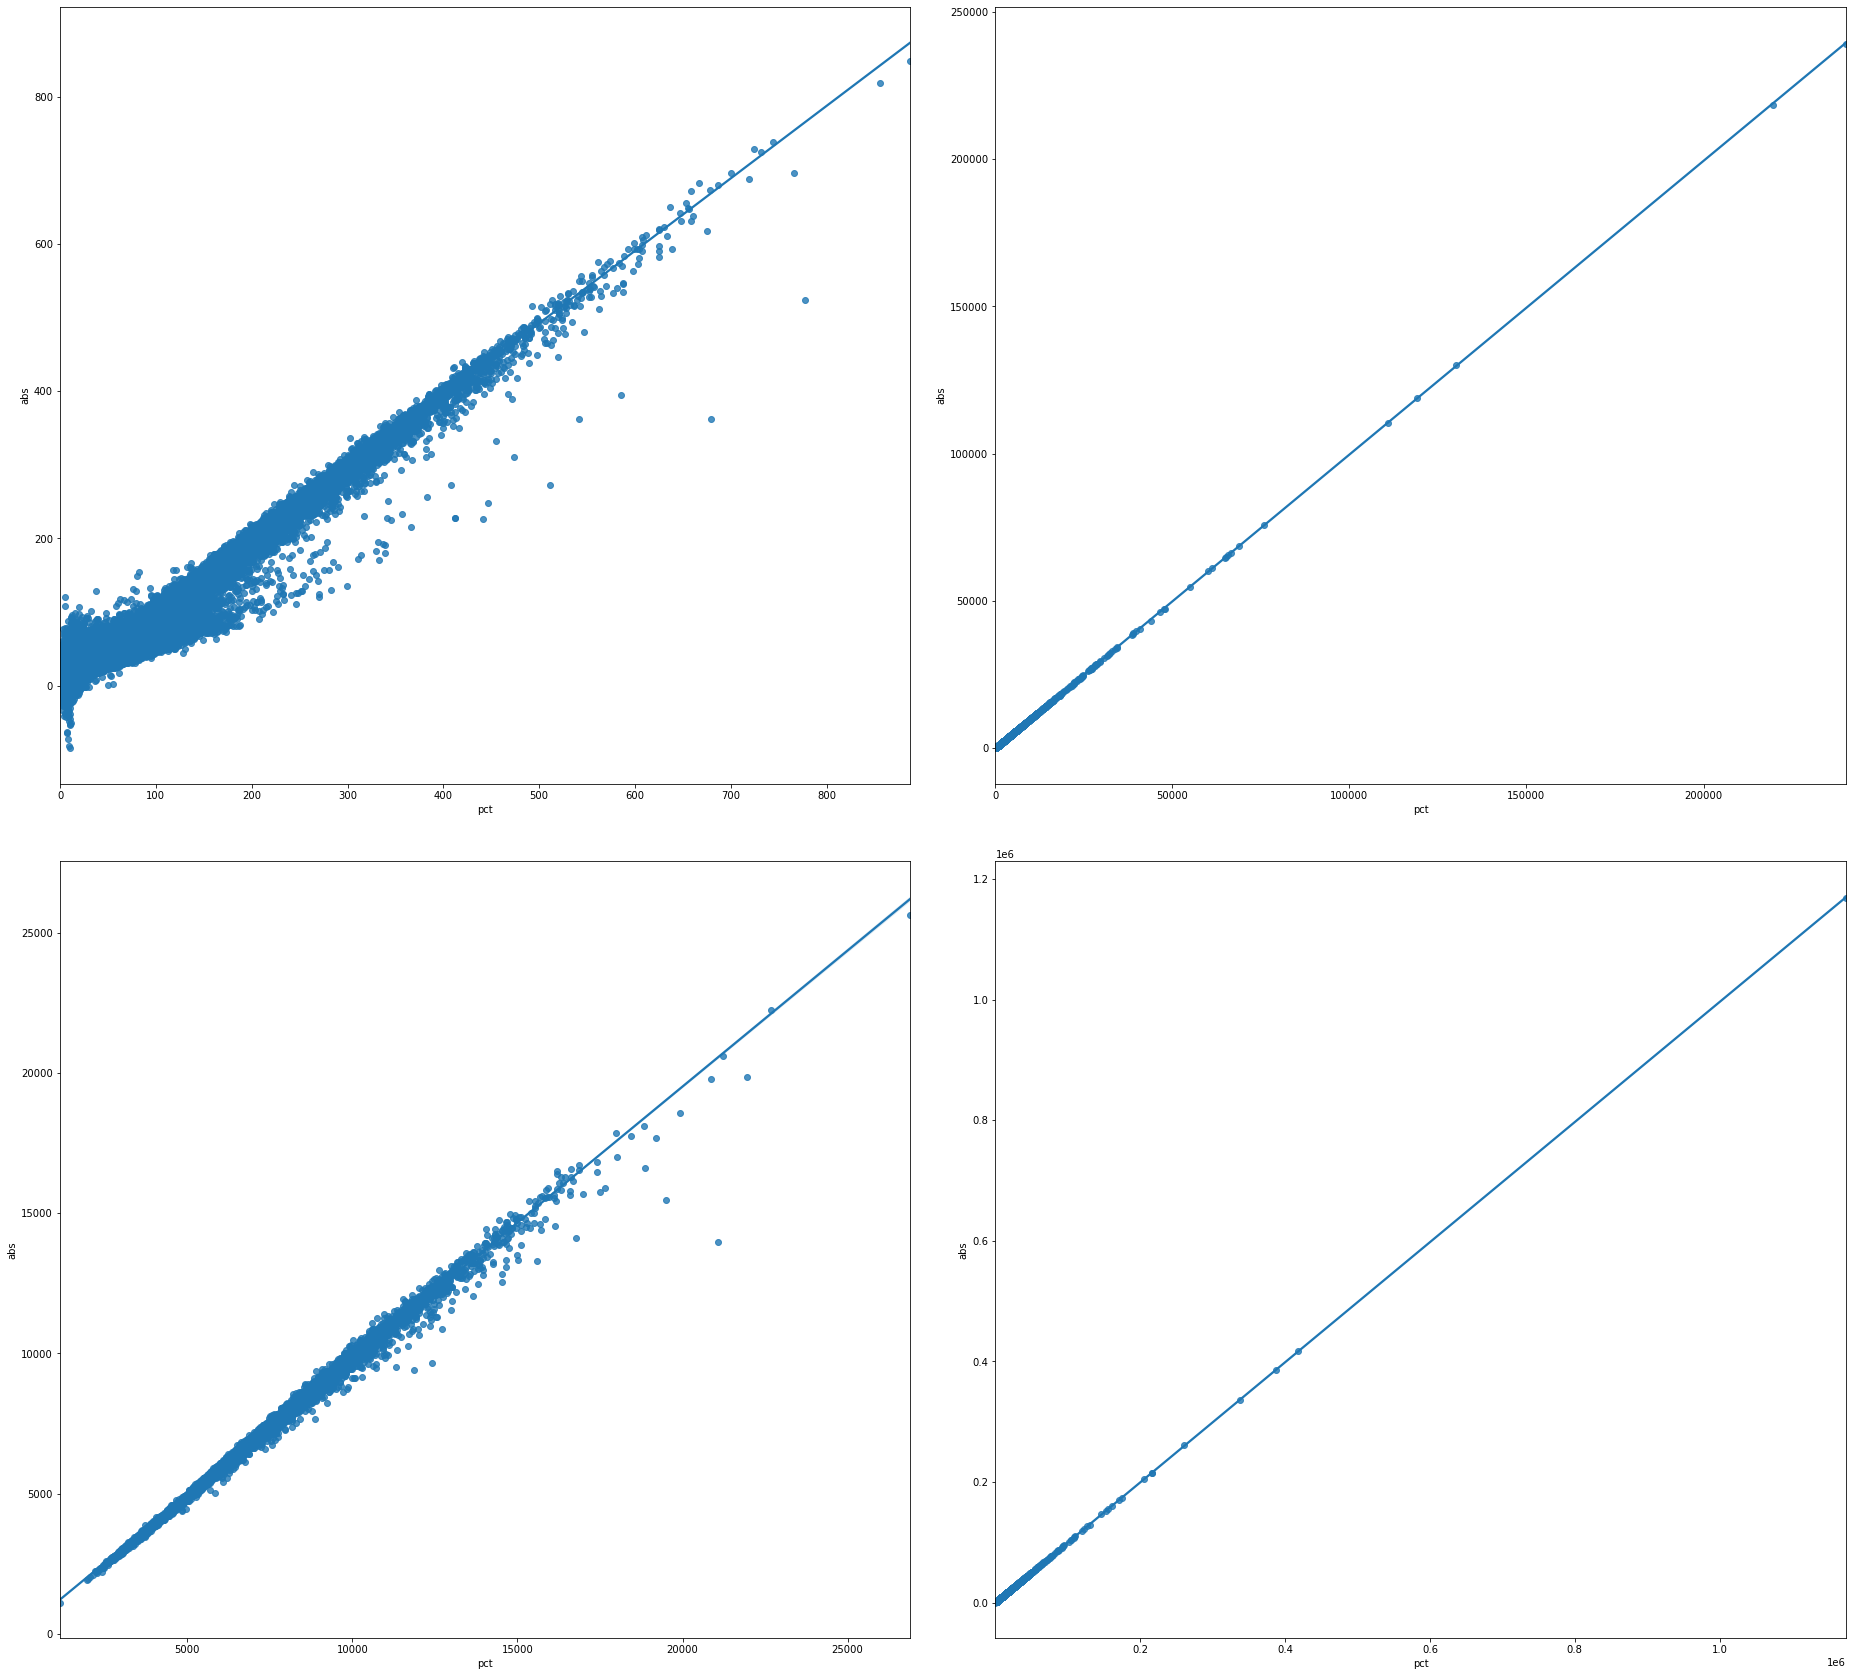

In [30]:
fig = pyplot.figure(figsize=(32,30))
fig.subplots_adjust(hspace=0.1,wspace=0.1)
ax1 = fig.add_subplot(2,2,1)
sns.regplot(x='pct',y='abs',data=pop_2021,ax=ax1)
ax2 = fig.add_subplot(2,2,2)
sns.regplot(x='pct',y='abs',data=emp_2021,ax=ax2)
ax3 = fig.add_subplot(2,2,3)
sns.regplot(x='pct',y='abs',data=pop_2021.groupby('msoa_zone_id').sum(),ax=ax3)
ax4 = fig.add_subplot(2,2,4)
sns.regplot(x='pct',y='abs',data=emp_2021.groupby('msoa_zone_id').sum(),ax=ax4)

<AxesSubplot:xlabel='pct', ylabel='abs'>

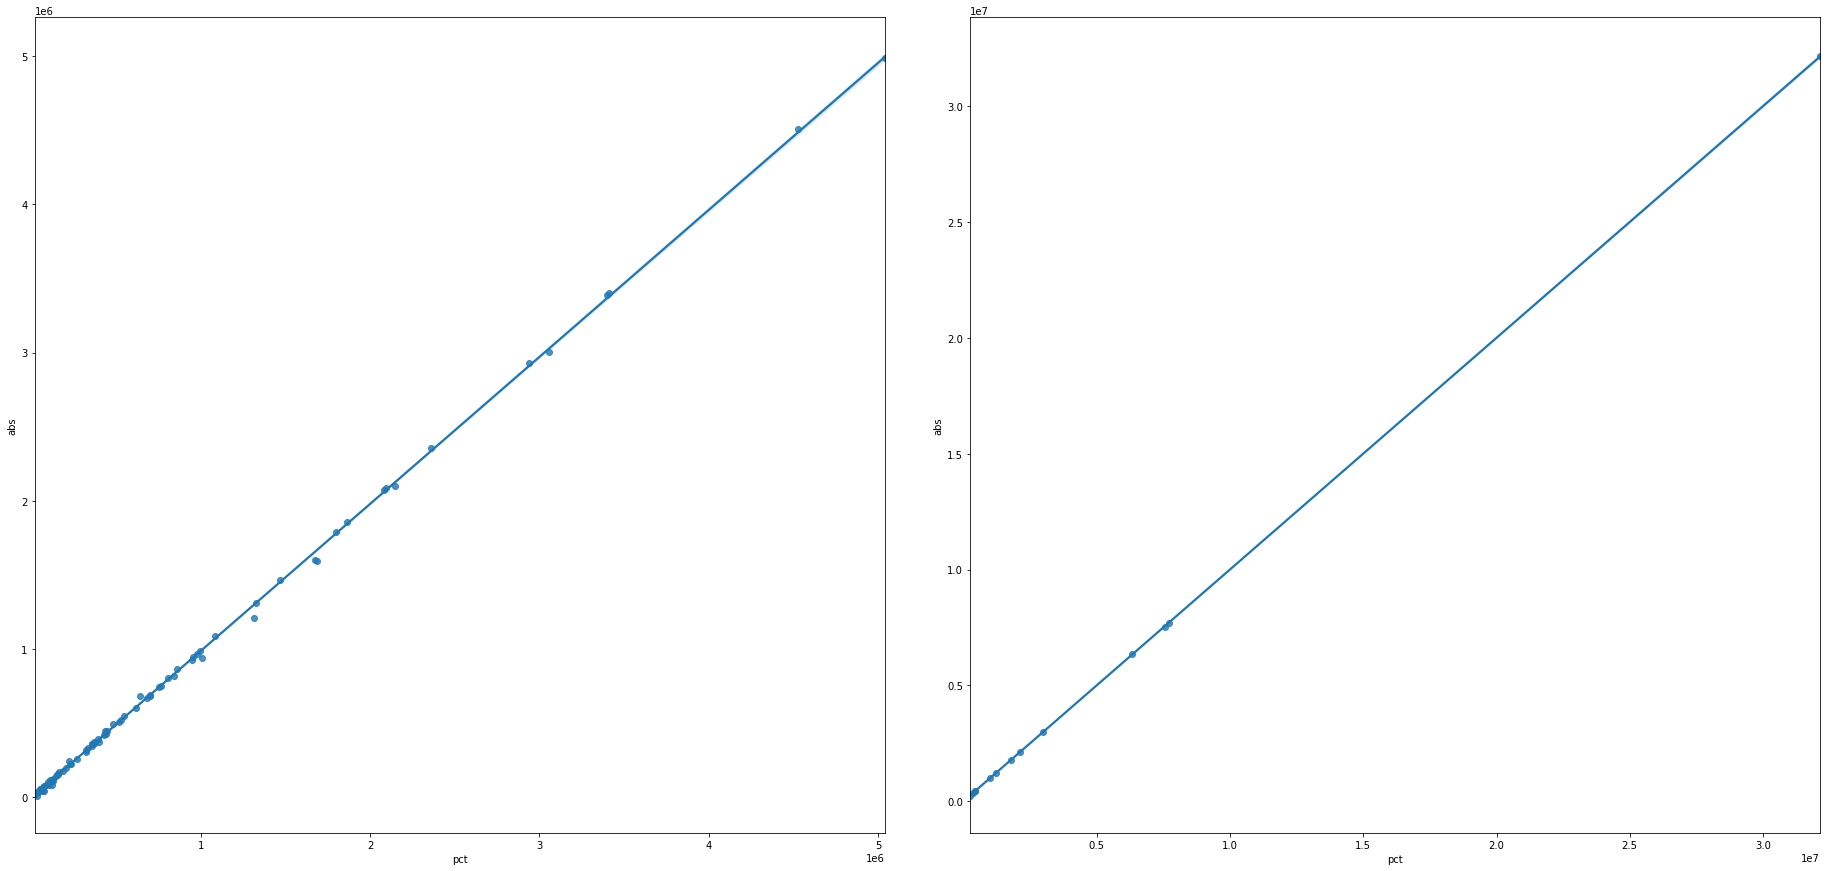

In [31]:
fig = pyplot.figure(figsize=(32,15))
fig.subplots_adjust(hspace=0.1,wspace=0.1)
ax3 = fig.add_subplot(1,2,1)
sns.regplot(x='pct',y='abs',data=pop_2021.groupby('pop code').sum(),ax=ax3)
ax4 = fig.add_subplot(1,2,2)
sns.regplot(x='pct',y='abs',data=emp_2021.groupby('emp code').sum(),ax=ax4)

In [11]:
df21 = pd.concat([pop_TfN_abs.groupby(['msoa_zone_id','pop code']).sum()['2021'],pop_NTEM['2021']],axis=1)

In [12]:
df21.columns = ['TfN','NTEM']

<AxesSubplot:xlabel='TfN', ylabel='NTEM'>

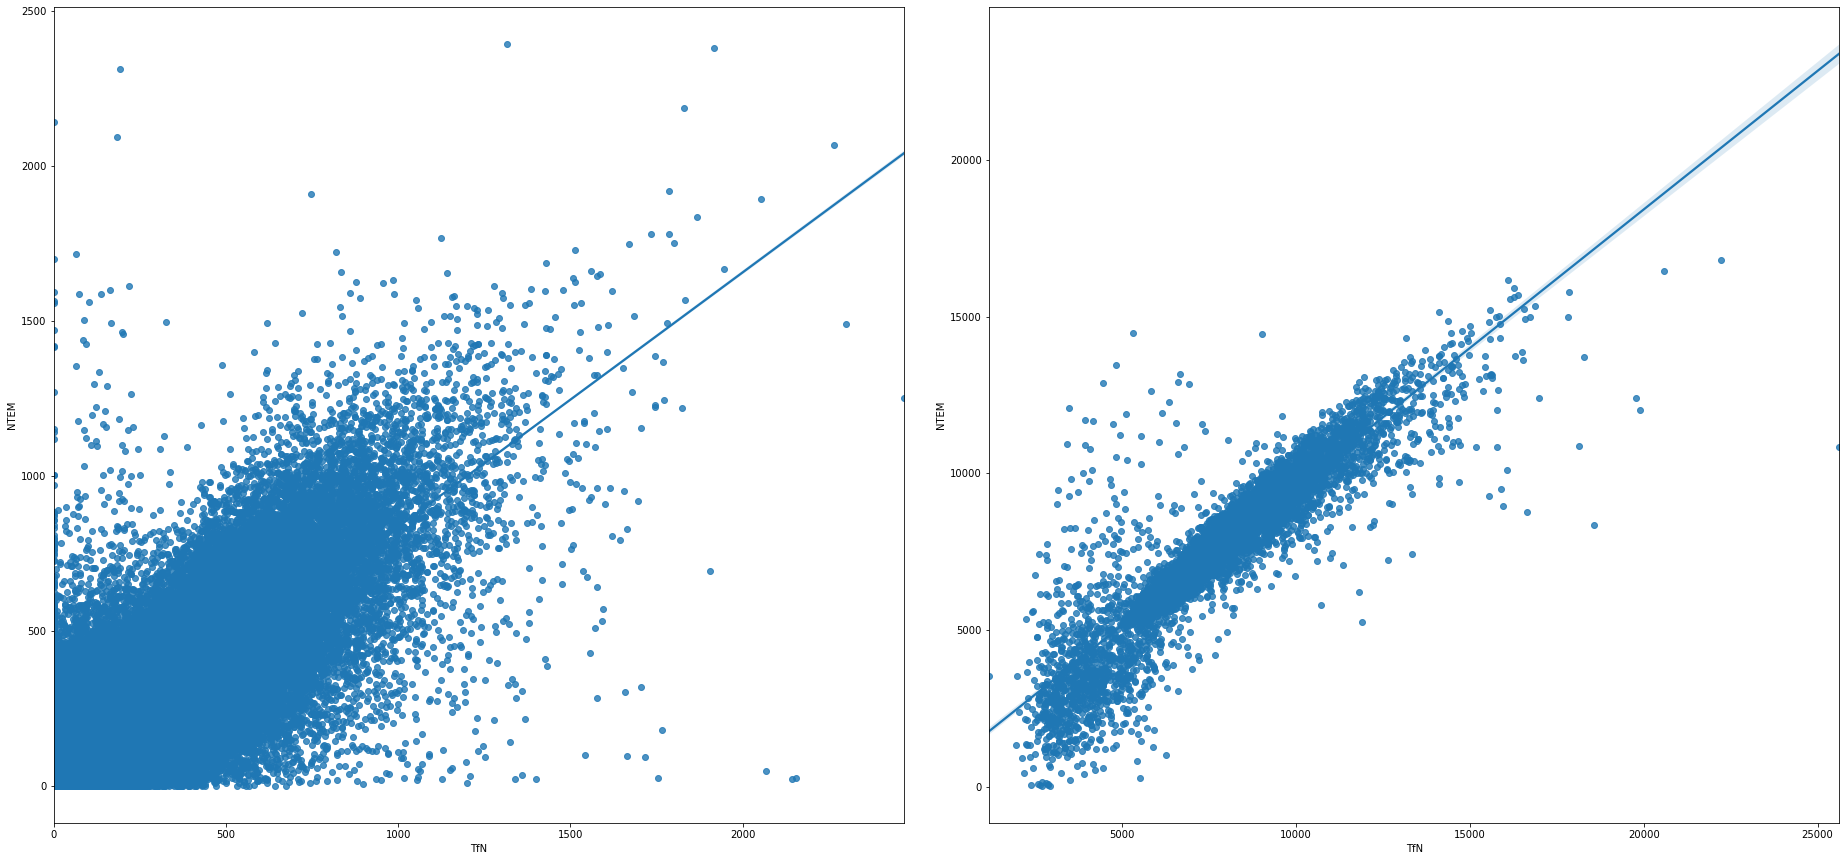

In [13]:
fig = pyplot.figure(figsize=(32,15))
fig.subplots_adjust(hspace=0.1,wspace=0.1)
ax3 = fig.add_subplot(1,2,1)
sns.regplot(x='TfN',y='NTEM',data=df21,ax=ax3)
ax4 = fig.add_subplot(1,2,2)
sns.regplot(x='TfN',y='NTEM',data=df21.groupby('msoa_zone_id').sum(),ax=ax4)

In [47]:
df21[df21['TfN']<0].min()

TfN    -312.858118
NTEM      0.415075
dtype: float64

The issue with absolute growth is that where segments don't match up perfectly, sometimes a negative growth is applied to a small or even zero TfN 2018 value, giving a negative 2021 value.  As this doesn't happen often and always to small initial values, these are set to zero. From all of this, we can see that although the population data doesn't match up perfectly we do get sensible growth numbers and 2021 values.

In [46]:
pop_TfN_abs[pop_TfN_abs['2021']<-20]

area type       2018  2018_grouped  \
msoa_zone_id pop code tfn_traveller_type                                       
E02000252    S006     27                          3   6.582744     22.304022   
                      28                          3   8.894355     22.304022   
E02000266    S006     28                          4  15.131662     37.180333   
E02000916    S006     28                          3  10.872393     26.806172   
E02002496    S006     28                          4  15.156392     35.613508   
...                                             ...        ...           ...   
S02001623    S030     310                         4   5.781998     13.544994   
             S070     670                         4   6.054445     14.507446   
S02001936    S030     310                         3  11.320128     23.759201   
             S070     670                         3  13.471367     28.334537   
W02000117    S070     666                         6   2.803972     10.486559   

                                              prop        diff       2021  
msoa_zone_id pop code tfn_traveller_type                                   
E02000252    S006     27                  0.295137  -91.871750 -20.532018  
                      28                  0.398778  -91.871750 -27.742085  
E02000266    S006     28                  0.406980  -91.396857 -22.065056  
E02000916    S006     28                  0.405593  -79.908582 -21.537959  
E02002496    S006     28                  0.425580  -85.193774 -21.100364  
...                                            ...         ...        ...  
S02001623    S030     310                 0.426873  -75.847119 -26.595121  
             S070     670                 0.417334 -103.301289 -37.056653  
S02001936    S030     310                 0.476452  -65.816304 -20.038207  
             S070     670                 0.475440  -90.802780 -29.699889  
W02000117    S070     666                 0.267387  -85.769019 -20.129565  

[65 rows x 6 columns]

In [17]:
pop_TfN_abs.droplevel('pop code')[['area type','2021']].to_csv(r"C:\Projects\MidMITS\NTEM\SHP\pop\abs_pop_formatted_nozero.csv")